In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
from math import sqrt
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('zillow-carlifornia.csv', index_col='Date')[:'2015-12-31']
df.columns = ['Price', 'Mortgage', 'UE']
train, val = df[:'2015-01-30'], df['2015-01-30':]
test = pd.read_csv('test.csv', index_col='Month')['Median House Price']

(-0.05879233004111535,
 0.9533914166134371,
 12,
 82,
 {'1%': -3.512738056978279,
  '5%': -2.8974898650628984,
  '10%': -2.585948732897085},
 1735.9812609931746)

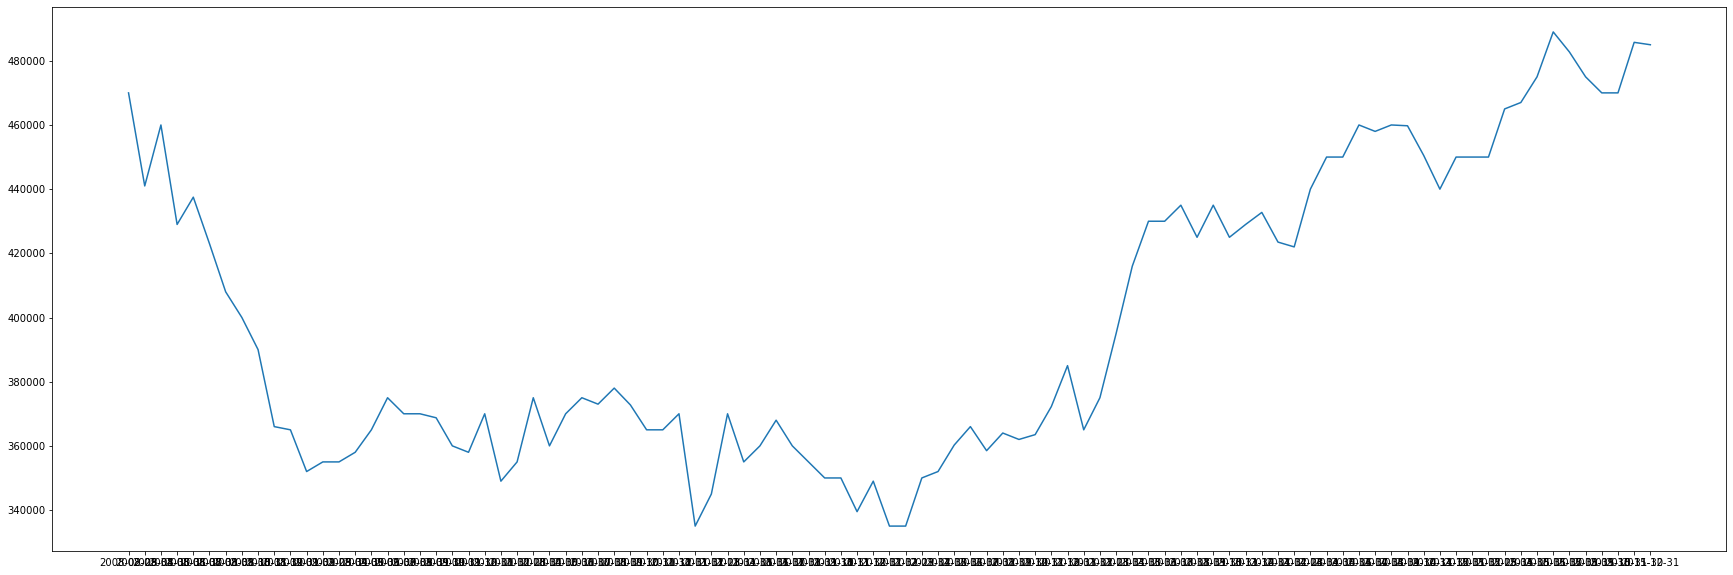

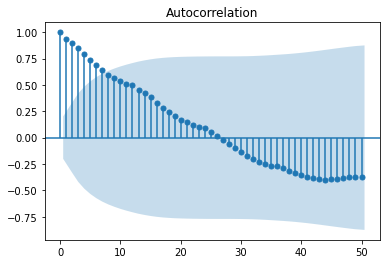

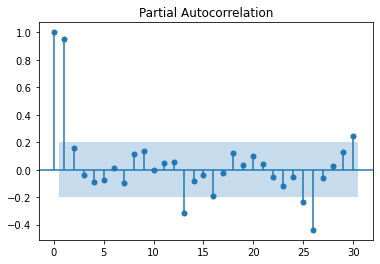

In [3]:
fig,ax = plt.subplots(figsize=(30, 10))
ax.plot(df['Price'])
plot_acf(df['Price'], lags=50)
plot_pacf(df['Price'], lags=30)
adfuller(df['Price'])

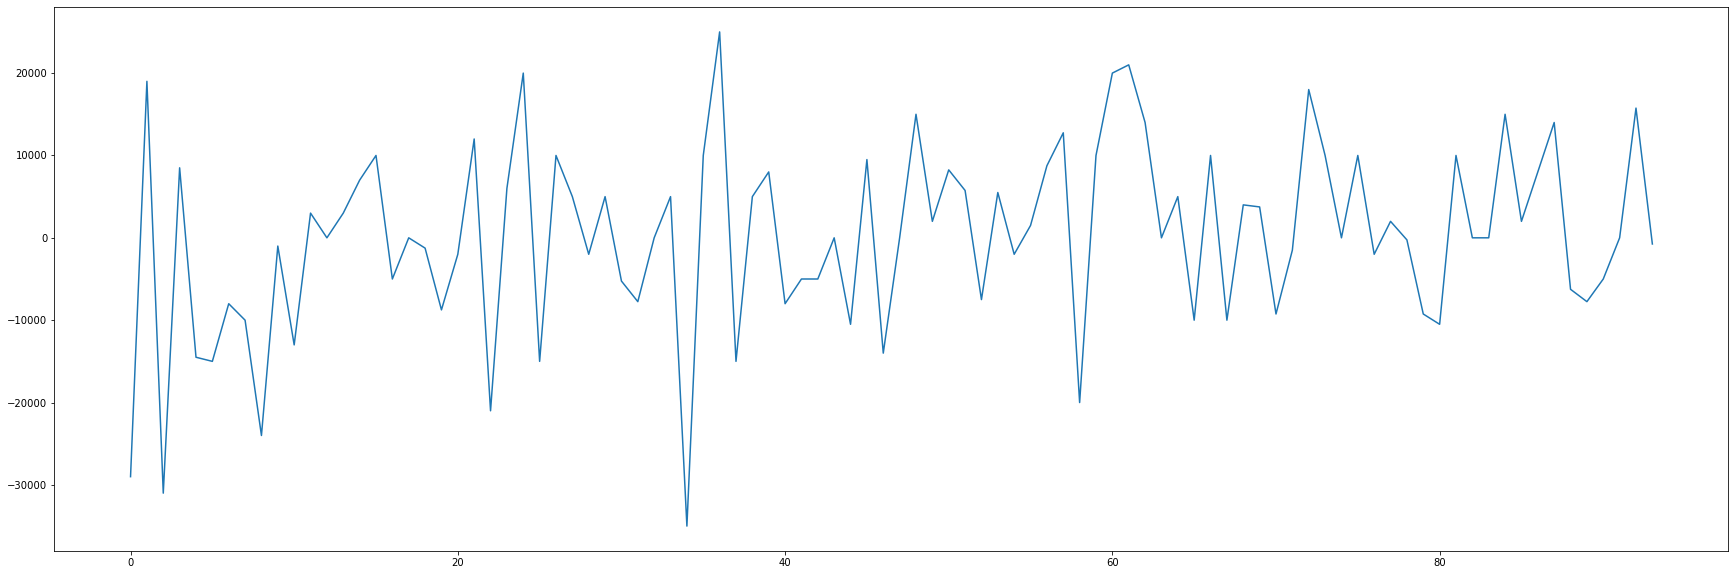

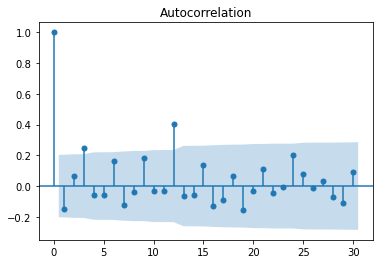

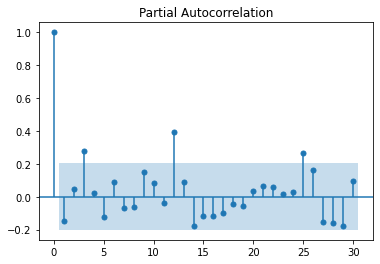

(-3.088139208146847,
 0.027443482891832627,
 11,
 82,
 {'1%': -3.512738056978279,
  '5%': -2.8974898650628984,
  '10%': -2.585948732897085},
 1713.9831737775294)

In [30]:
def diff(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff

d1 = diff(df['Price'])
fig,ax = plt.subplots(figsize=(30, 10))
ax.plot(d1)
plot_acf(d1, lags=30)
plot_pacf(d1, lags=30)
plt.show()
adfuller(d1)

### SARIMA
Candidate model: (2,1,4), (1,1,1,12)

In [3]:
def rmse_sarima(X, trend_order, seasonal_order, split_size): #added split_size
    train_size = int(len(X) * split_size)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = sm.tsa.statespace.SARIMAX(history, order=trend_order,seasonal_order=seasonal_order)
        res = model.fit()
        yhat = res.predict(start=len(history), end=len(history)) #predict one step
        predictions.append(yhat) #store prediction
        history.append(test[t]) #store observation
        # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse
def evaluate_rmse_sarima(data, p_values,d_values,q_values,P_values,Q_values,m, D=1):
    best_score, best_order, best_seasonal_order = float("inf"), None, None
    count=0
    for p in p_values:
        for d in d_values:
            for q in q_values:
                    for P in P_values:
                            for Q in Q_values:
                                order=(p,d,q)
                                seasonal_order=(P,D,Q,m)
                                count+=1
                                sys.stdout.write(f'\r{count}/400')
                                sys.stdout.flush
                                try:
                                    rmse=rmse_sarima(data,trend_order=order, seasonal_order=seasonal_order, 
                                                     split_size=.67)
                                    if rmse < best_score:
                                        best_score, best_order, best_seasonal_order=rmse, order,seasonal_order
                                except:
                                    continue
    print((best_score, best_order, best_seasonal_order))

evaluate_rmse_sarima(df['Price'].values.ravel(), range(5), [1,2], range(5), range(2), range(4), 12, 1)

400/400(9471.864379007722, (2, 1, 4), (1, 1, 1, 12))


In [28]:
model = sm.tsa.statespace.SARIMAX(train['Price'],order=(2, 1, 4),seasonal_order=(1,1,1,12)).fit()
y_pred = model.forecast(len(val))
sqrt(mean_squared_error(val['Price'], y_pred))

9239.009868739562

### ETS
Candidate model: Trend=None, Seasonal=additive, m=12

In [8]:
def evaluate_es_model_rmse(X,Trend, Seasonal,m,damped=True):
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ExponentialSmoothing(history, trend=Trend,seasonal=Seasonal,seasonal_periods=m, damped=damped)
        res = model.fit()
        yhat = res.forecast()[0] #predict one step
        predictions.append(yhat) #store prediction
        history.append(test[t]) #store observation
        # calculate out of sample error
    rmse=sqrt(mean_squared_error(test, predictions))
    return rmse

In [11]:
df["Price"]

Date
2008-02-29    470000.0
2008-03-31    441000.0
2008-04-30    460000.0
2008-05-31    429000.0
2008-06-30    437500.0
                ...   
2015-08-31    475000.0
2015-09-30    470000.0
2015-10-31    470000.0
2015-11-30    485750.0
2015-12-31    485000.0
Name: Price, Length: 95, dtype: float64

In [14]:
rmse_1=evaluate_es_model_rmse(df['Price'], Trend="additive", Seasonal="additive",m=12,damped=True)
#rmse_2=evaluate_es_model_rmse(df['Price'], Trend="multiplicative", Seasonal="additive",m=12,damped=True)
rmse_3=evaluate_es_model_rmse(df['Price'], Trend="additive", Seasonal="multiplicative",m=12,damped=True)
#rmse_4=evaluate_es_model_rmse(df['Price'], Trend="multiplicative", Seasonal="multiplicative",m=12,damped=True)
rmse_5=evaluate_es_model_rmse(df['Price'], Trend=None, Seasonal="additive",m=12,damped=False)
rmse_6=evaluate_es_model_rmse(df['Price'], Trend=None, Seasonal="multiplicative",m=12,damped=False)

In [15]:
rmse_1, rmse_3, rmse_5, rmse_6

(10288.955765731205, 10235.764150863597, 9969.983392463353, 10223.236742244222)

In [17]:
model_ets=ExponentialSmoothing(train['Price'], trend=None, seasonal="additive", damped=False, seasonal_periods=12)
result_ets=model_ets.fit()
pred_ets=result_ets.forecast(len(val))
pred_ets.index=val.index
sqrt(mean_squared_error(val['Price'], pred_ets))

22185.598649384232

In [19]:
#Sanity check on test set
model_ets=ExponentialSmoothing(df['Price'], trend=None, seasonal="additive", damped=False, seasonal_periods=12)
result_ets=model_ets.fit()
pred_ets=result_ets.forecast(len(test))
pred_ets.index = test.index
test = pd.read_csv('test.csv', index_col='Month')['Median House Price']
sqrt(mean_squared_error(test, pred_ets))

18783.722543869888

### Prophet

In [13]:
train_prophet = pd.DataFrame({'ds': train.index, 'y': train['Price'], 'UE': train['UE'], 'Mortgage': train['Mortgage']})
val_prophet = pd.DataFrame({'ds': val.index, 'y': val['Price'], 'UE': val['UE'], 'Mortgage': val['Mortgage']})

In [15]:
from fbprophet import Prophet
m = Prophet()
m.add_regressor('UE')
m.add_regressor('Mortgage')
#model_2=m.add_seasonality(name='yearly', period=12, fourier_order=3)
m.fit(train_prophet)
future_2 = m.make_future_dataframe(periods=len(val), freq='m')
future_2['Mortgage'] = df['Mortgage'].values
future_2['UE'] = df['UE'].values
forecast_2 = m.predict(future_2).set_index('ds')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [17]:
sqrt(mean_squared_error(val['Price'], forecast_2.loc[list(val.index), 'yhat']))

8804.672957546602

In [33]:
train_prophet = pd.DataFrame({'ds': df.index, 'y': df['Price'], 'UE': df['UE'], 'Mortgage': df['Mortgage']})
a = pd.read_csv('zillow-carlifornia.csv', index_col='Date')[['MedianMortageRate', 'UnemploymentRate']]
from fbprophet import Prophet
m = Prophet()
m.add_regressor('UE')
m.add_regressor('Mortgage')
#model_2=m.add_seasonality(name='yearly', period=12, fourier_order=3)
m.fit(train_prophet)
future_2 = m.make_future_dataframe(periods=len(test1), freq='m')
future_2['Mortgage'] = a['MedianMortageRate'].values
future_2['UE'] = a['UnemploymentRate'].values
forecast_2 = m.predict(future_2).set_index('ds')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [34]:
sqrt(mean_squared_error(test1['y'], forecast_2.loc[list(test1.index), 'yhat']))

7720.22433309713

### VAR

In [15]:

train_diff = train.diff().dropna()
print(adfuller(train_diff['Mortgage']))
print(adfuller(train_diff['UE']))



(-7.919917783569889, 3.748176379666451e-12, 0, 81, {'1%': -3.5137900174243235, '5%': -2.8979433868293945, '10%': -2.5861907285474777}, -45.50934261115074)
(-1.6269141335077826, 0.4691063877403307, 11, 70, {'1%': -3.5274258688046647, '5%': -2.903810816326531, '10%': -2.5893204081632653}, 11.104925058154237)


In [16]:
train_diff2 = train_diff.diff().dropna()
print(adfuller(train_diff2['Mortgage']))
print(adfuller(train_diff2['UE']))

(-4.915902574344767, 3.2472092646902076e-05, 8, 72, {'1%': -3.524624466842421, '5%': -2.9026070739026064, '10%': -2.5886785262345677}, -25.981097822786055)
(-14.825919184219101, 1.931790202871924e-27, 10, 70, {'1%': -3.5274258688046647, '5%': -2.903810816326531, '10%': -2.5893204081632653}, 13.085171871526981)


In [41]:
from statsmodels.tsa.api import VAR
model = VAR(train_diff2)
results = model.fit(maxlags=15, ic='bic')

In [24]:
pred = results.forecast(results.y, steps=len(val))
dt_forecast = pd.DataFrame(pred, index=val.index, columns=val.columns + '_1d')

,Price_1d,Mortgage_1d,UE_1d
Date,,,
2015-08-31,2906.821026,0.071628,-0.141615
2015-09-30,-5281.061492,0.003376,0.028748
2015-10-31,2006.474981,-0.017700,0.203291
2015-11-30,2945.296150,-0.033491,-0.138350
2015-12-31,-3246.153201,0.020983,-0.056423


In [25]:
def invert_transformation(dt_train, dt_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    dt_fc = dt_forecast.copy()
    columns = train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            dt_fc[str(col)+'_1d'] = (train[col].iloc[-1]-train[col].iloc[-2]) + dt_fc[str(col)+'_1d'].cumsum()
        # Roll back 1st Diff
        dt_fc[str(col)+'_forecast'] = train[col].iloc[-1] + dt_fc[str(col)+'_1d'].cumsum()
    return dt_fc

### SARIMAX
Candidate Model: (2,1,2), (0,1,0,12)

In [11]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))

train_sc = sc.fit_transform(train)
val_sc = sc.transform(val)

In [115]:
def bic_sarima(data, exog, p_values,d_values,q_values,P_values,Q_values,m_values, D=1): #added m_values
    best_score, best_order, best_seasonal_order = float("inf"), None, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                    for P in P_values:
                            for Q in Q_values:
                                for m in m_values:
                                    order=(p,d,q)
                                    seasonal_order=(P,D,Q,m)
                                    try:
                                        res = sm.tsa.statespace.SARIMAX(data, exog=exog, order=order,seasonal_order=seasonal_order,enforce_stationarity=False,enforce_invertibility=False).fit()
                                        bic=res.bic
                                        if bic < best_score:
                                            best_score, best_order, best_seasonal_order=bic, order,seasonal_order
                                    except:
                                        continue
    print((best_score, best_order, best_seasonal_order))

bic_sarima(train_sc[:,0], train_sc[:,1:], range(5), range(2), range(5), range(4), range(4), [12], D=1)

(-189.78007342545624, (2, 1, 2), (0, 1, 0, 12))


In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model= SARIMAX(endog=train_sc[:,0], exog=train_sc[:,1:], order=(2, 1, 2),seasonal_order=(0,1,0,12), enforce_invertibility=False, enforce_stationarity=False)
results= model.fit()
forecast= results.forecast(steps=len(val), exog=val_sc[:,1:]).reshape(-1,1)
y_pred_ = np.repeat(forecast,3,axis=1)
y_pred_inv = sc.inverse_transform(y_pred_)[:,0]

In [13]:
sqrt(mean_squared_error(val['Price'], y_pred_inv))

25068.103401367625

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


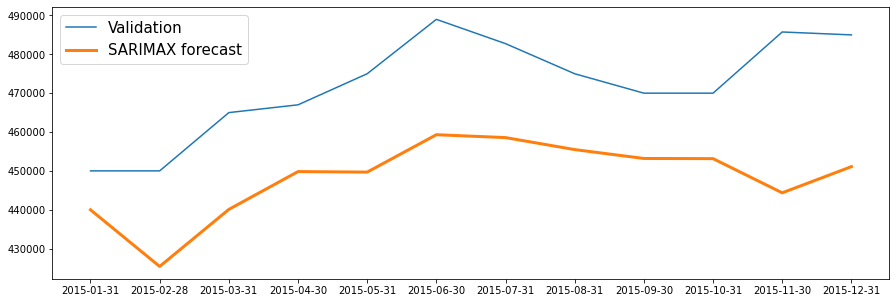

In [14]:
# forecasting
plt.figure(figsize=(15, 5))

plt.plot(val.Price, label='Validation')
plt.plot(y_pred_inv, label='SARIMAX forecast', lw=3)
plt.legend(loc='upper left', fontsize=15)
plt.show()

### Overall RMSE on validation data

In [26]:
results = pd.DataFrame({'Model': ['SARIMA', 'ETS', 'SARIMAX', 'Prophet'], 'RMSE': [9232, 22185, 25039, 8804]})
results

,Model,RMSE
0,SARIMA,9232
1,ETS,22185
2,SARIMAX,25039
3,Prophet,8804


### Test results

In [4]:
train_prophet = pd.DataFrame({'ds': df.index, 'y': df['Price'], 'UE': df['UE'], 'Mortgage': df['Mortgage']})
a = pd.read_csv('zillow-carlifornia.csv', index_col='Date')[['MedianMortageRate', 'UnemploymentRate']] # Get all of secondary variables including test set
from fbprophet import Prophet
m = Prophet()
m.add_regressor('UE')
m.add_regressor('Mortgage')
m.fit(train_prophet)
future_2 = m.make_future_dataframe(periods=len(test), freq='m')
future_2['Mortgage'] = a['MedianMortageRate'].values
future_2['UE'] = a['UnemploymentRate'].values
forecast_2 = m.predict(future_2).set_index('ds')
sqrt(mean_squared_error(test, forecast_2.loc[list(test.index), 'yhat']))

Importing plotly failed. Interactive plots will not work.
INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


7720.224328050629

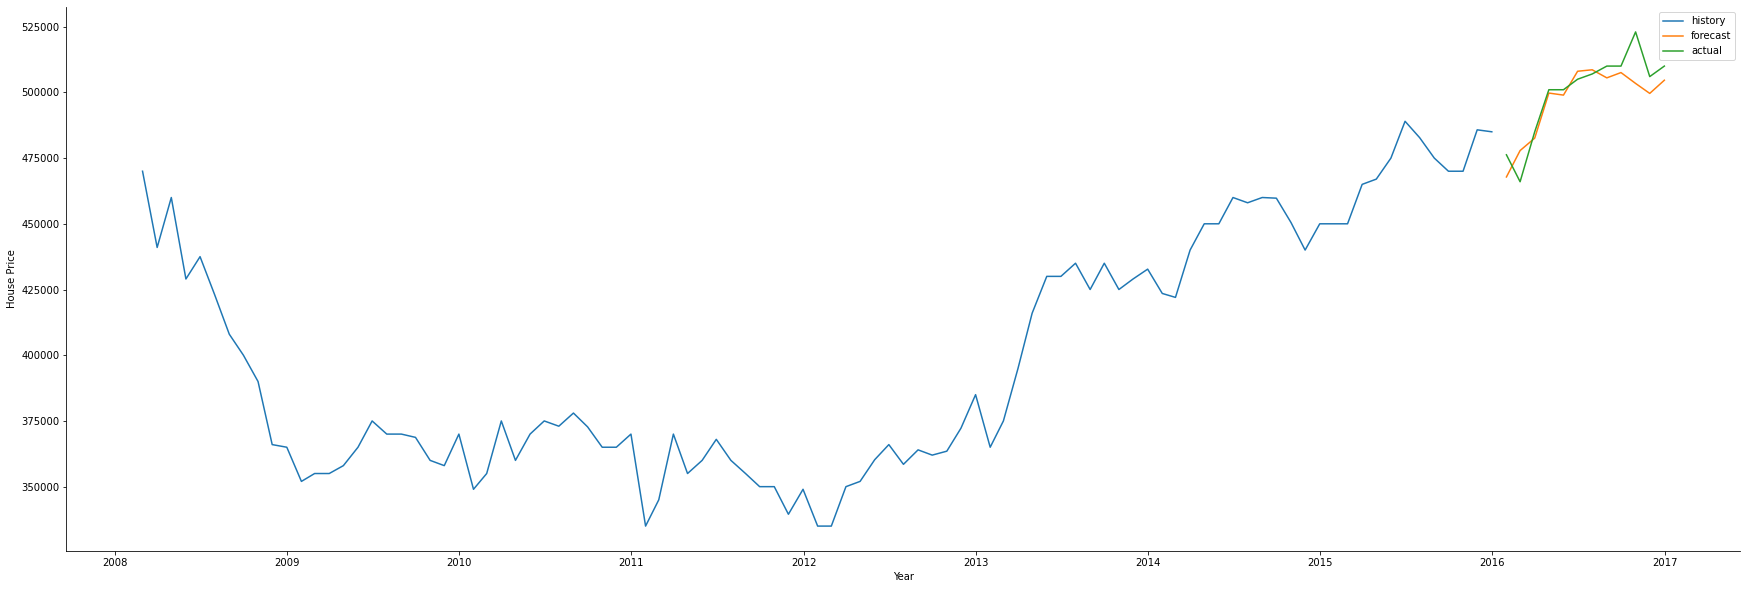

In [5]:
fig, ax = plt.subplots(figsize=(30, 10))
df.index = df.index.astype('datetime64[ns]')
test.index = test.index.astype('datetime64[ns]')
ax.plot(df['Price'], label='history')
ax.plot(forecast_2.loc[list(test.index), 'yhat'], label='forecast')
ax.plot(test, label='actual')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Year')
ax.set_ylabel('House Price')
plt.legend()
plt.savefig('forecast.png')

In [9]:
forecast_2.loc[list(test.index), 'yhat'].values

array([467816.86238104, 477859.92883443, 482593.59373626, 499735.2672508 ,
       498958.37406671, 508035.07123601, 508589.69904718, 505518.58190429,
       507531.73883215, 503399.52108529, 499605.32729803, 504623.82746729])

In [7]:
test

Month
2016-01-31    476250
2016-02-29    466000
2016-03-31    485000
2016-04-30    501000
2016-05-31    501000
2016-06-30    505000
2016-07-31    507000
2016-08-31    510000
2016-09-30    510000
2016-10-31    523000
2016-11-30    506000
2016-12-31    510000
Name: Median House Price, dtype: int64

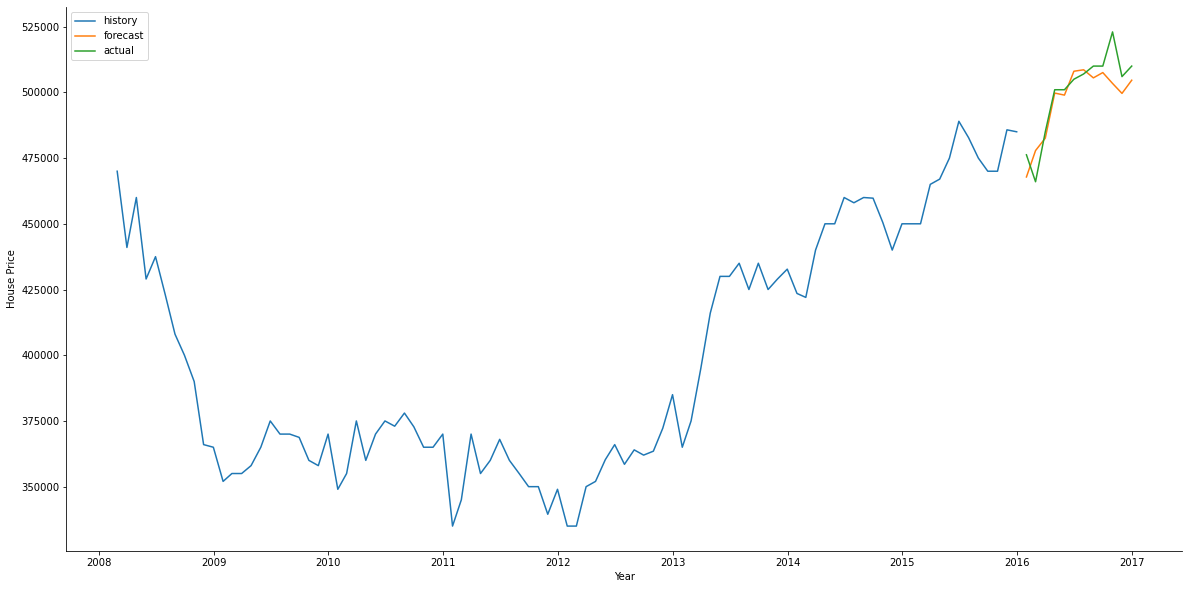

In [8]:
fig, ax = plt.subplots(figsize=(20, 10))
df.index = df.index.astype('datetime64[ns]')
test.index = test.index.astype('datetime64[ns]')
ax.plot(df['Price'], label='history')
ax.plot(forecast_2.loc[list(test.index), 'yhat'], label='forecast')
ax.plot(test, label='actual')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Year')
ax.set_ylabel('House Price')
plt.legend()
plt.savefig('forecast.png')